In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

from easydict import EasyDict as edict
import matplotlib.pyplot as plt

# modules
from dataloader import Cifar10DataLoader, MnistDataLoader
from dnn import DNN
from unet import UNet,CUNet

In [ ]:
dataloader_args = edict({"batch_size": 256, "epochs": 50, "da": False})
# dataloader = MnistDataLoader(dataloader_args=dataloader_args)
dataloader = Cifar10DataLoader(dataloader_args=dataloader_args)
train_dataset, valid_dataset, test_dataset = dataloader.load_dataset()

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Predicted Image', 'Test Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def plot_train(display_list):
  # plt.figure(figsize=(10, 10))
  label = ['Train', 'Test']
  for i in range(len(display_list)):
    plt.plot(display_list[i], label=label[i])
  plt.legend()
  plt.show()
  

In [ ]:
model_args = edict({"units":[128,64,32,10], "activations":["relu","relu","relu","softmax"]})
model = DNN(units=model_args.units, activations=model_args.activations)

In [ ]:
train_loss_fn = tf.keras.losses.CategoricalCrossentropy()
mt_loss_fn = tf.keras.metrics.Mean()
test_loss_fn = tf.keras.losses.CategoricalCrossentropy()
mte_loss_fn = tf.keras.metrics.Mean()
opt_loss_fn = tf.keras.losses.categorical_crossentropy

train_metrics = tf.keras.metrics.CategoricalAccuracy()
test_metrics = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD(0.1)

In [ ]:
# @tf.function(experimental_relax_shapes=True, experimental_compile=None)
def _train_step(inputs, labels, first_batch=False):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = train_loss_fn(labels, predictions)
        metrics = tf.reduce_mean(train_metrics(labels, predictions))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    mt_loss_fn.update_state(loss)
    
    return loss, metrics

def _test_step(inputs, labels):
    predictions = model(inputs)
    loss = test_loss_fn(labels, predictions)
    opt_loss = opt_loss_fn(labels, predictions)
    metrics = tf.reduce_mean(test_metrics(labels, predictions))
    mte_loss_fn.update_state(loss)
    
    return loss, metrics, opt_loss

In [ ]:
iter_train = iter(train_dataset)
iter_valid = iter(valid_dataset)
iter_test = iter(test_dataset)
test_data =  iter_test.get_next()

display([test_data["inputs"][0],test_data["inputs"][1],test_data["inputs"][2]])

In [ ]:
model_opt = []
opt_label = []
def collect_model_operator(variables, loss):
    weights = [w.numpy() for w in variables]
    opt = DNN(units=model_args.units, 
            activations=model_args.activations,
            init_value=weights)
    opt_label.append(loss)
    model_opt.append(opt)

records = edict({'epoch':[],'train_loss':[],'test_loss':[],'train_metric':[],'test_metric':[]})
def obtain_model_opts(sample_start=30, sample_gap=20):
    for e in range(dataloader.info.epochs):
        mt_loss_fn.reset_states()
        train_metrics.reset_states()
        mte_loss_fn.reset_states()
        test_metrics.reset_states()
        for step in range(dataloader.info.train_step):
            data = iter_train.get_next()
            train_loss, acc = _train_step(inputs=data["inputs"], labels=data["labels"])
            if (e*dataloader.info.train_step + step)%sample_gap ==0:
                if e >= sample_start:
                    test_loss, test_acc, opt_loss = _test_step(inputs=test_data["inputs"], labels=test_data["labels"])
                    collect_model_operator(model.trainable_variables, opt_loss)
                    
        test_loss, test_acc, _ = _test_step(inputs=test_data["inputs"], labels=test_data["labels"])
        records.epoch        += [e]
        records.train_loss   += [mt_loss_fn.result().numpy()]
        records.train_metric += [train_metrics.result().numpy()]
        records.test_loss    += [mte_loss_fn.result().numpy()]
        records.test_metric  += [test_metrics.result().numpy()]
        log = ""
        for k,v in records.items():
            log += "{}: {} ".format(k,v[-1])
        print(log)

In [ ]:

def init_model_opt(raw_model_opt, data):
    
    def opt_test_step(opt, inputs, labels):
        predictions = opt(inputs)
        loss = test_loss_fn(labels, predictions)
        metrics = tf.reduce_mean(test_metrics(labels, predictions))
        mte_loss_fn.update_state(loss)
        return loss, metrics

    for idx in range(len(raw_model_opt)):
        mte_loss_fn.reset_states()
        test_metrics.reset_states()
        for step in range(1):
            data = test_data
            test_loss, test_acc = opt_test_step(opt=raw_model_opt[idx], inputs=data["inputs"], labels=data["labels"])
        print("Init: opt_id:{}, Test loss:{}, Test acc:{}".format(idx,
                                                        mte_loss_fn.result().numpy(),
                                                        test_metrics.result().numpy()))
            
def hard_save_model_opt(online_model_opt, path="./model_opt"):
    init_model_opt(online_model_opt, test_data)
    for idx in range(len(online_model_opt)):
        mpath = os.path.join(path, "opt_{}".format(idx))
        online_model_opt[idx].save(mpath, overwrite=True, save_format='tf')

def load_model_opt(path="./model_opt"):
    offline_model_opt = []
    model_opt_list = os.listdir(path=path)
    for idx in range(len(model_opt_list)):
        mpath = os.path.join(path,  "opt_{}".format(idx))
        offline_model_opt.append(tf.keras.models.load_model(mpath))
    init_model_opt(offline_model_opt, test_data)
    return offline_model_opt

In [39]:
GIAO_EPOCH = 1000
GIAO_BATCH = 1

giao_optimizer = tf.keras.optimizers.Adam(1e-3)
giao_loss_fn = tf.keras.losses.MeanSquaredError()
def _opt_train_step(unet, regs, train_inputs, train_labels, labels):
    gradients = []
    losses = []
    for idx in range(len(regs)):
        with tf.GradientTape() as tape:
            pseudo_inputs = unet(train_inputs)
            # pseudo_inputs = train_inputs
            predictions = regs[idx](pseudo_inputs)
            reg_loss = opt_loss_fn(train_labels, predictions)
            # print(reg_loss, labels[idx])
            giao_loss = giao_loss_fn(labels[idx], reg_loss)
            # giao_loss = tf.math.reduce_sum(labels[idx]-reg_loss)
            losses.append(giao_loss)
            # print(giao_loss)
            grad = tape.gradient(giao_loss, unet.model.trainable_variables)
            if gradients == []:
                gradients = grad
            else:
                gradients = [sg1+sg2 for sg1,sg2 in zip(grad, gradients)]
        
    reduced_grads = [g/GIAO_BATCH for g in gradients]
    giao_optimizer.apply_gradients(zip(reduced_grads, unet.model.trainable_variables))
    reduced_loss = sum(losses)/GIAO_BATCH
    return reduced_loss, pseudo_inputs

In [38]:

train_data = iter_train.get_next()

# unet = UNet(input_shape=[32, 32, 3])
unet = CUNet(input_shape=[32, 32, 3])

Epoch:0 GIAO Train Loss:0.020455164834856987


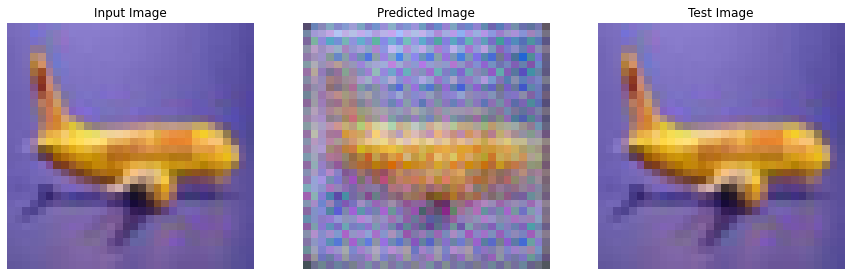

Epoch:25 GIAO Train Loss:0.02458084747195244


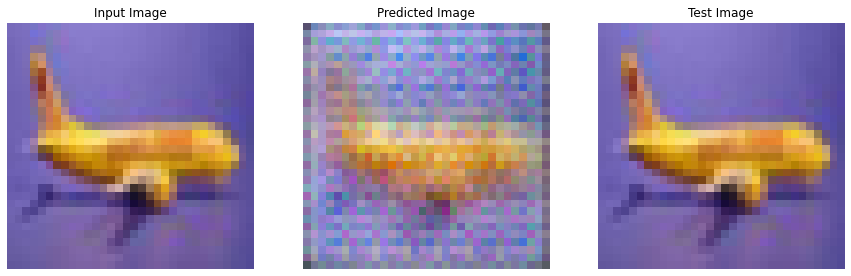

Epoch:50 GIAO Train Loss:0.02146855555474758


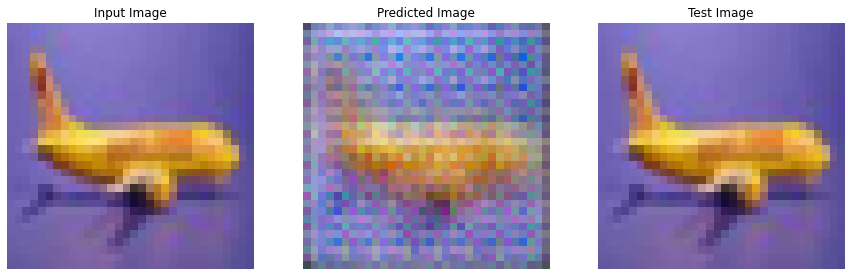

Epoch:75 GIAO Train Loss:0.011915527284145355


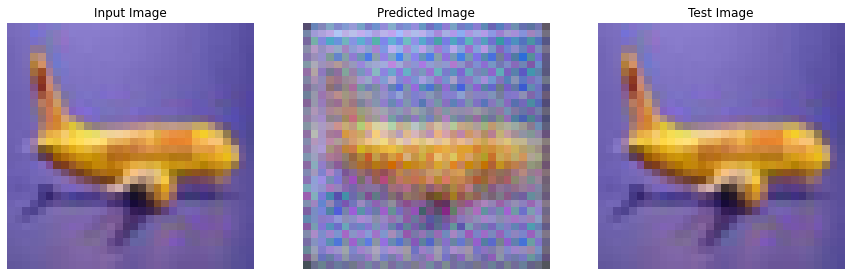

Epoch:100 GIAO Train Loss:0.016544628888368607


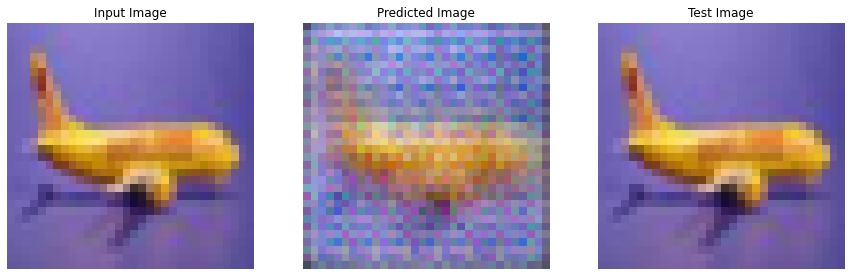

Epoch:125 GIAO Train Loss:0.014835422858595848


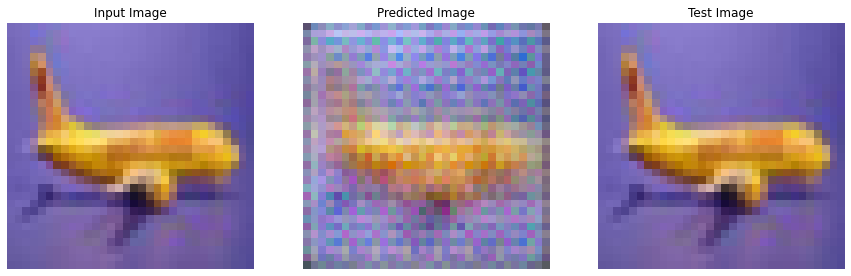

Epoch:150 GIAO Train Loss:0.033346377313137054


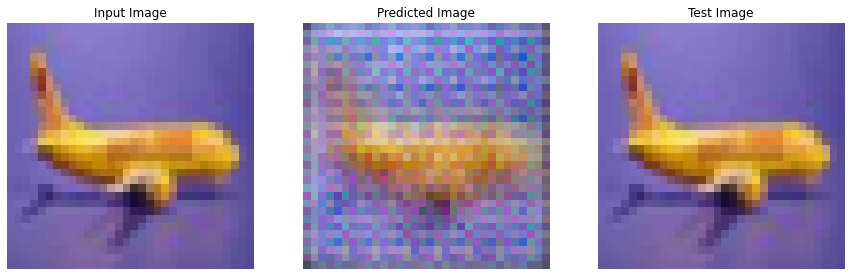

Epoch:175 GIAO Train Loss:0.018875502049922943


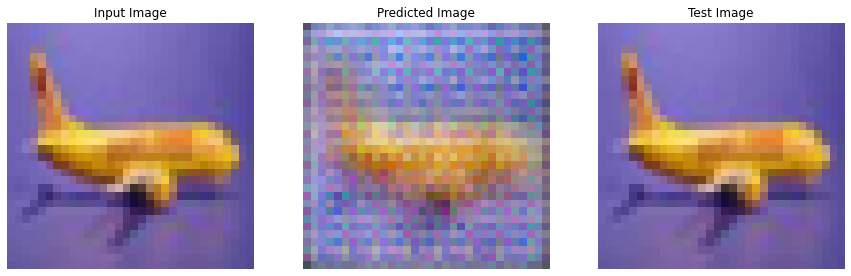

Epoch:200 GIAO Train Loss:0.010309171862900257


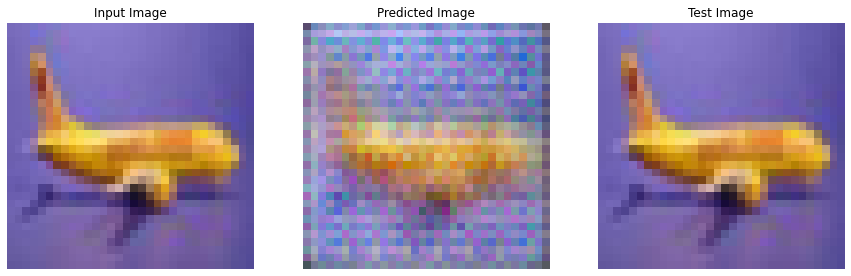

Epoch:225 GIAO Train Loss:0.011220989748835564


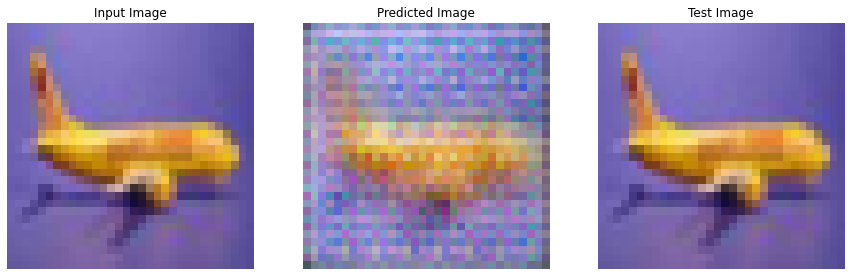

Epoch:250 GIAO Train Loss:0.011710488237440586


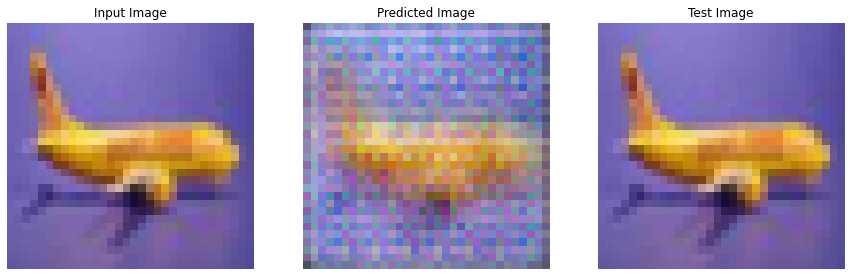

Epoch:275 GIAO Train Loss:0.0069985100999474525


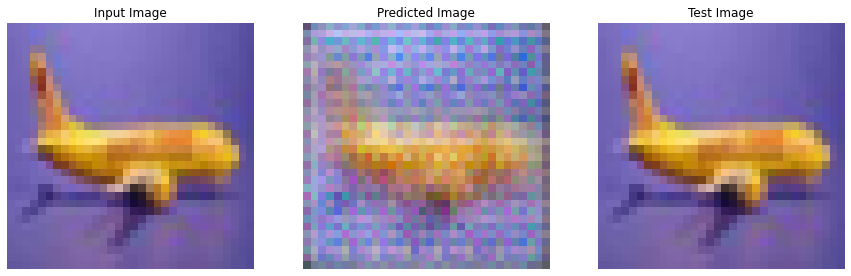

Epoch:300 GIAO Train Loss:0.009580401703715324


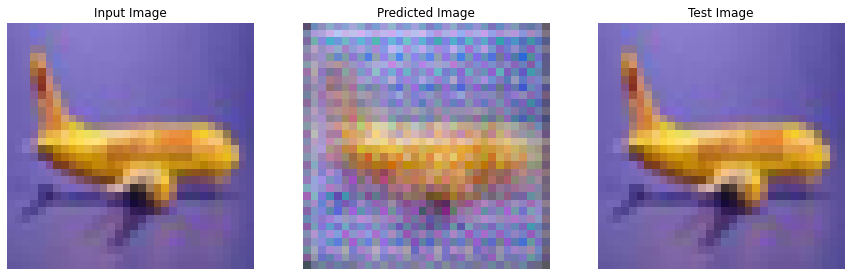

Epoch:325 GIAO Train Loss:0.006283184513449669


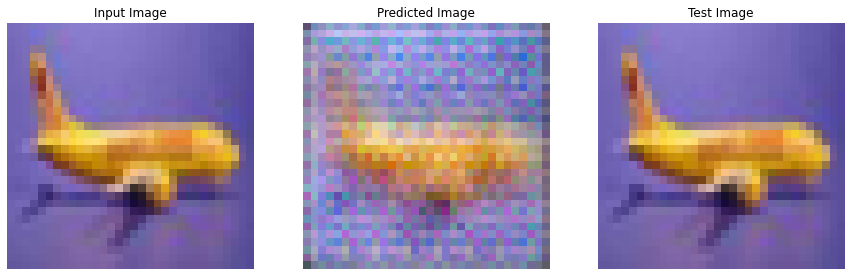

Epoch:350 GIAO Train Loss:0.010200319811701775


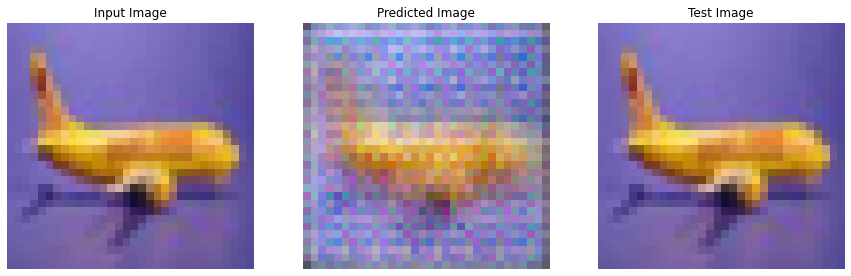

Epoch:375 GIAO Train Loss:0.03888363018631935


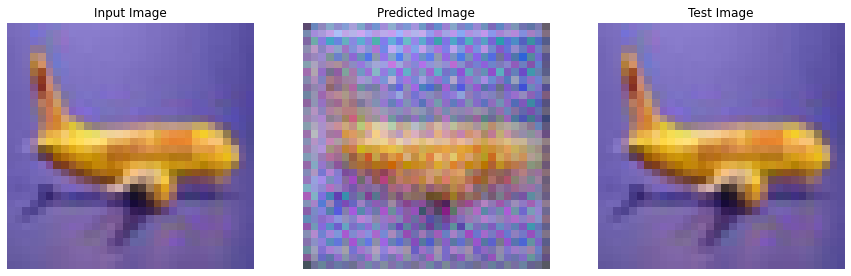

Epoch:400 GIAO Train Loss:0.024548739194869995


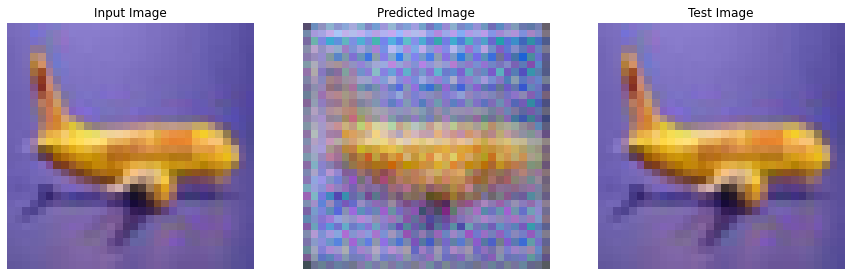

Epoch:425 GIAO Train Loss:0.015964509919285774


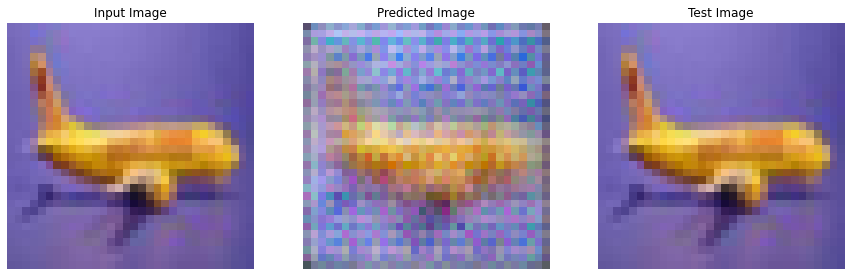

Epoch:450 GIAO Train Loss:0.01790916919708252


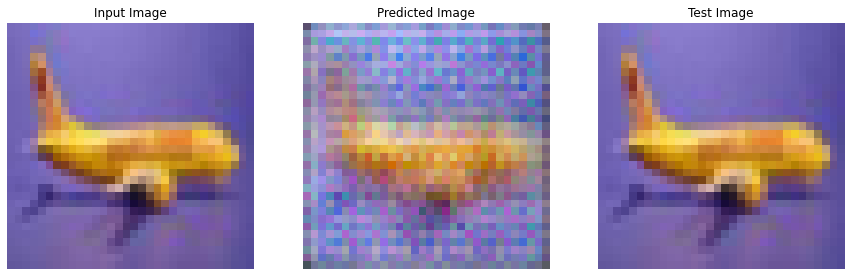

Epoch:475 GIAO Train Loss:0.013674365356564522


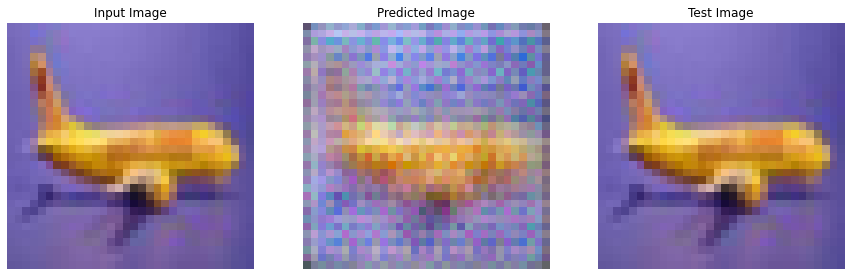

Epoch:500 GIAO Train Loss:0.011548087000846863


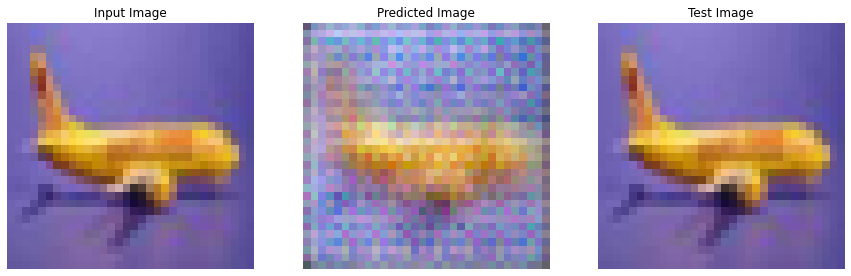

Epoch:525 GIAO Train Loss:0.011523977853357792


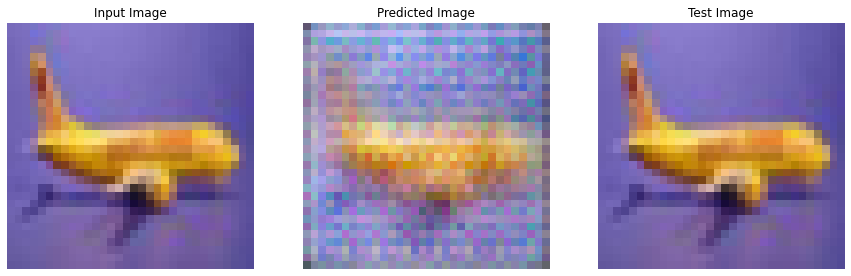

Epoch:550 GIAO Train Loss:0.02185998111963272


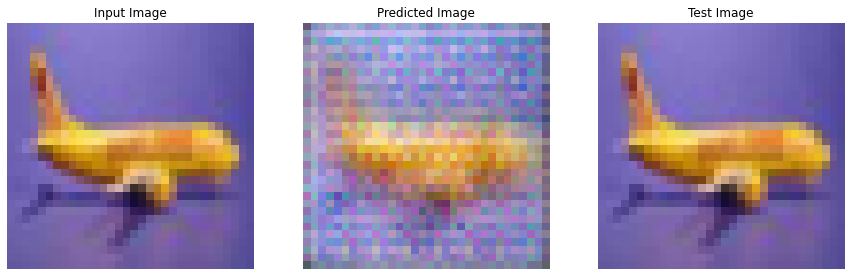

Epoch:575 GIAO Train Loss:0.006650594528764486


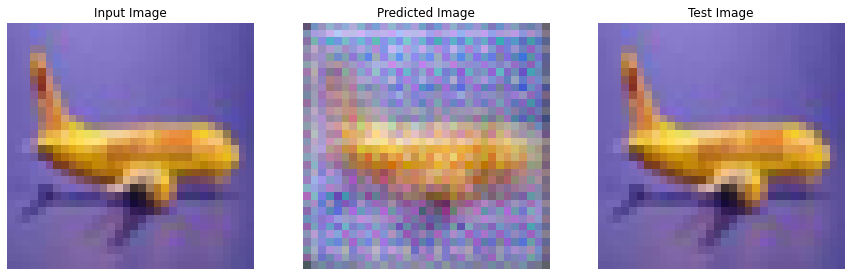

Epoch:600 GIAO Train Loss:0.008111022412776947


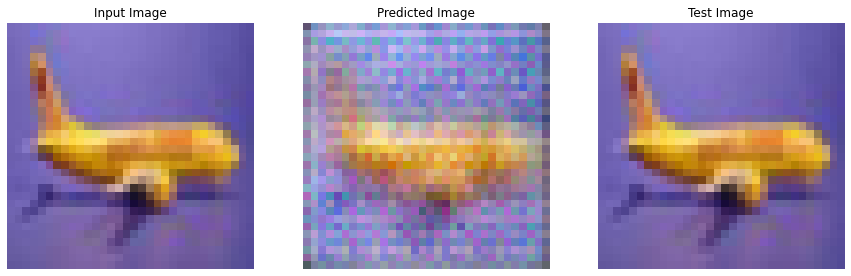

Epoch:625 GIAO Train Loss:0.007282970938831568


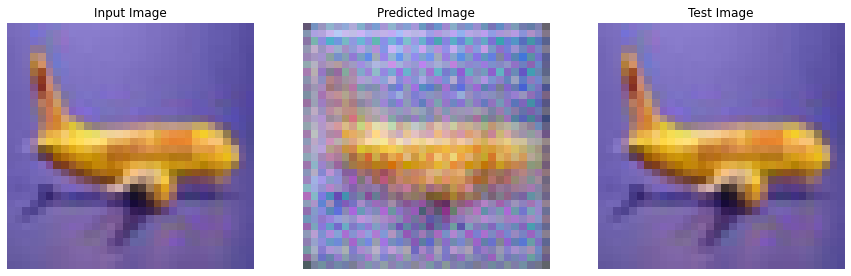

Epoch:650 GIAO Train Loss:0.008847659453749657


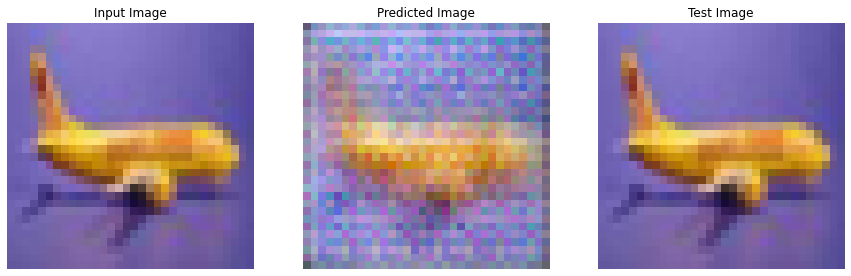

Epoch:675 GIAO Train Loss:0.011791326105594635


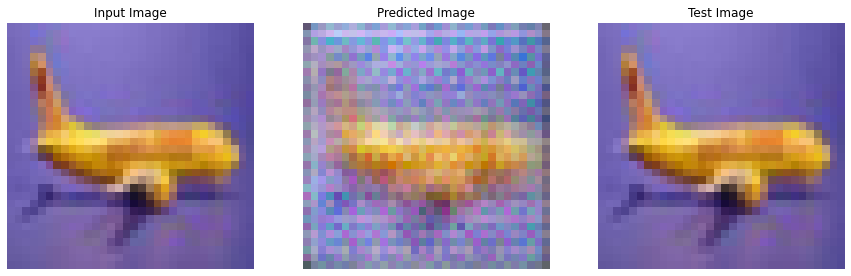

Epoch:700 GIAO Train Loss:0.015353251248598099


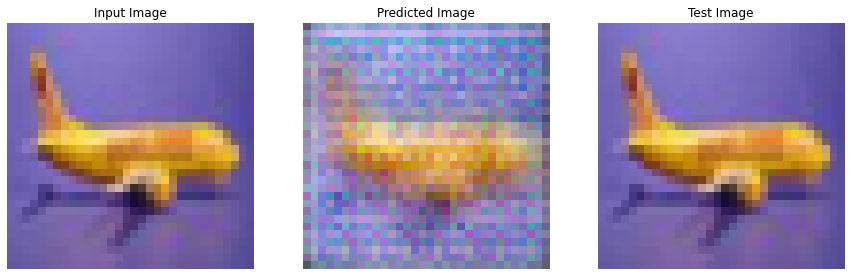

Epoch:725 GIAO Train Loss:0.011970964260399342


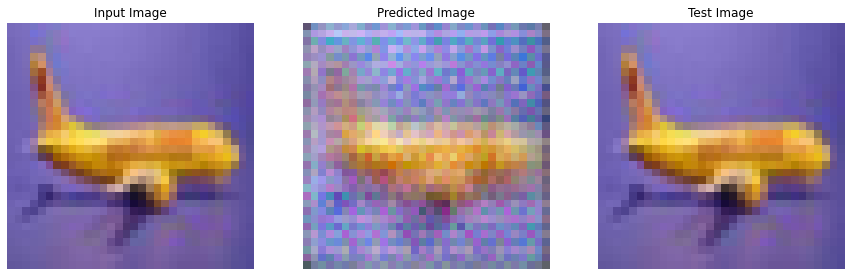

Epoch:750 GIAO Train Loss:0.006392354145646095


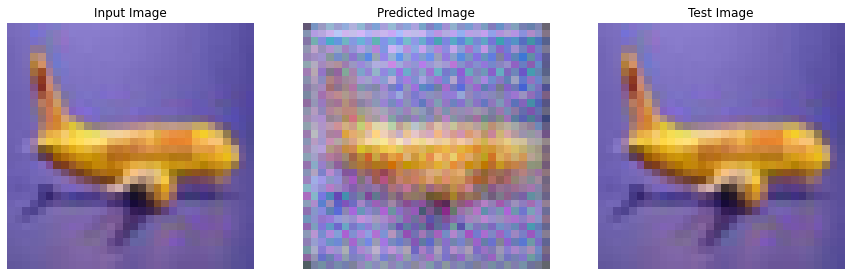

Epoch:775 GIAO Train Loss:0.005770349409431219


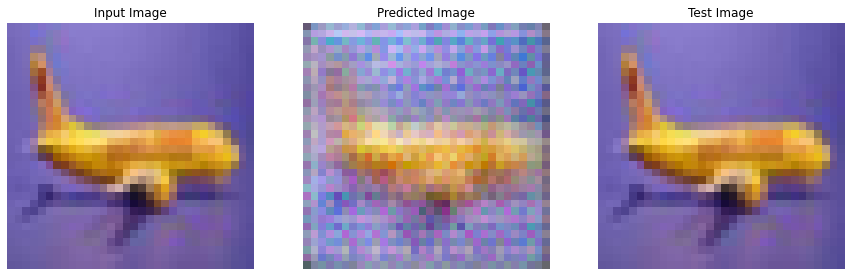

Epoch:800 GIAO Train Loss:0.006861413829028606


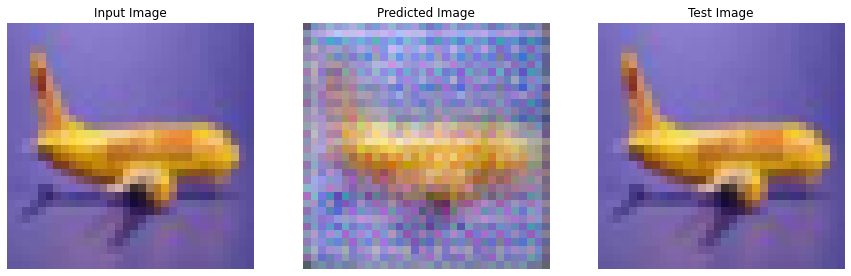

Epoch:825 GIAO Train Loss:0.008314657025039196


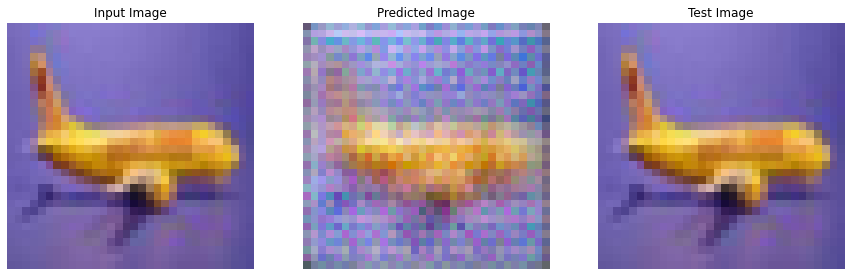

Epoch:850 GIAO Train Loss:0.005238400772213936


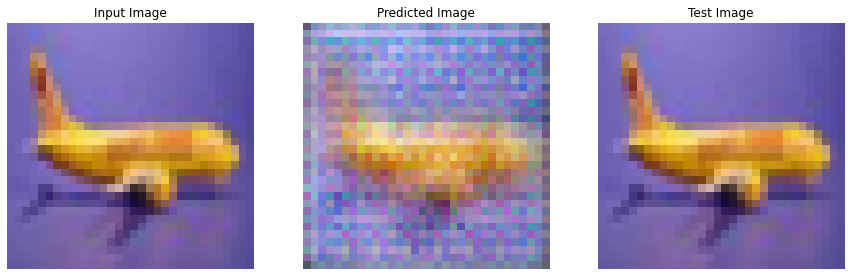

Epoch:875 GIAO Train Loss:0.0038488598074764013


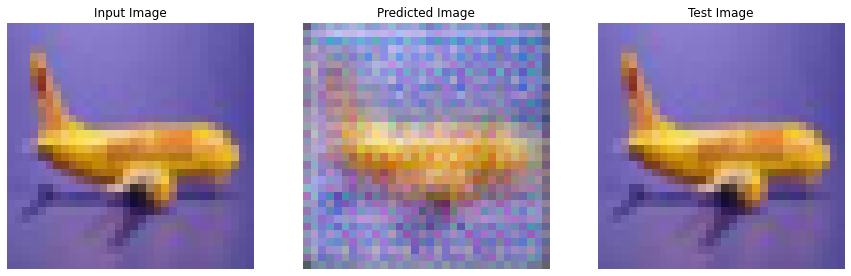

Epoch:900 GIAO Train Loss:0.007975847460329533


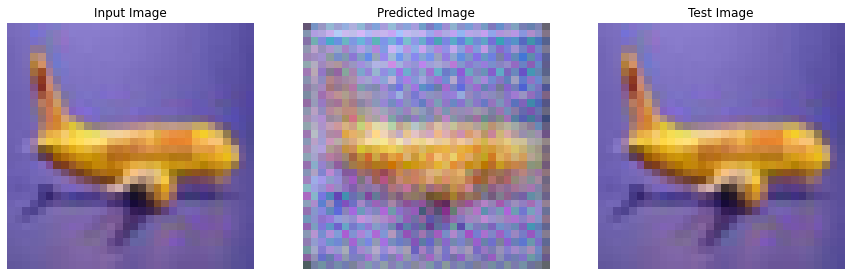

Epoch:925 GIAO Train Loss:0.005158980842679739


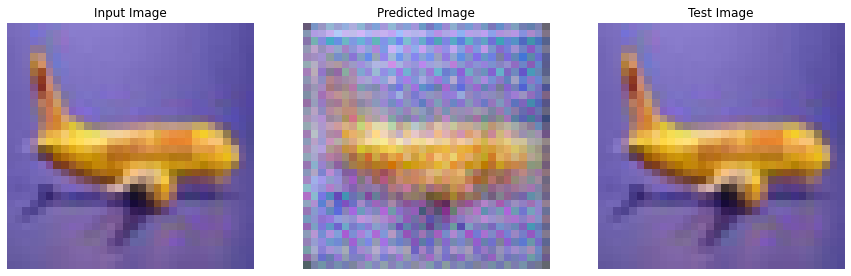

Epoch:950 GIAO Train Loss:0.007352182641625404


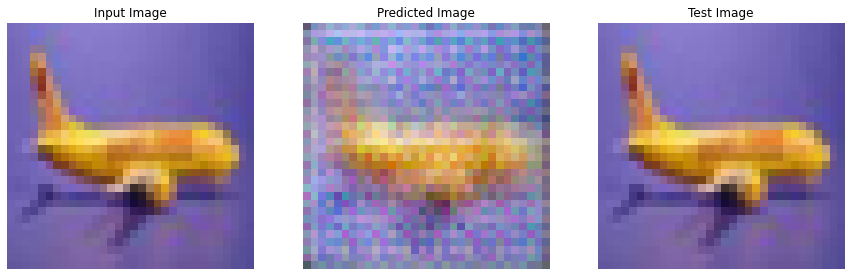

Epoch:975 GIAO Train Loss:0.005641949363052845


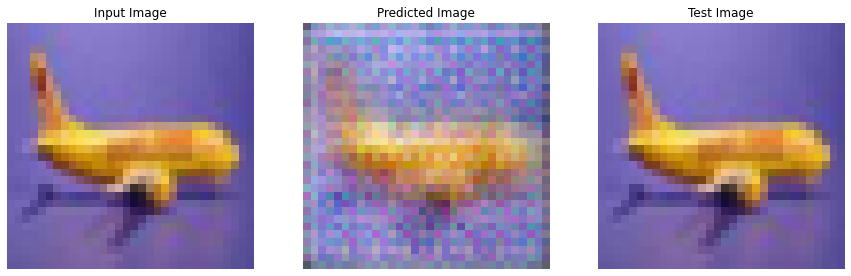

In [41]:

for i in range(GIAO_EPOCH):
    idx = random.sample(range(len(model_opt)), GIAO_BATCH)
    labels = [opt_label[i] for i in idx]
    regs = [model_opt[i] for i in idx]
    giao_train_loss, pseudo_inputs = _opt_train_step(unet, regs, test_data["inputs"], test_data["labels"], labels)
    if i % 25 == 0:
        print("Epoch:{} GIAO Train Loss:{}".format(i, giao_train_loss))
        display([test_data["inputs"].numpy()[0], pseudo_inputs.numpy()[0], test_data["inputs"][0]])
        

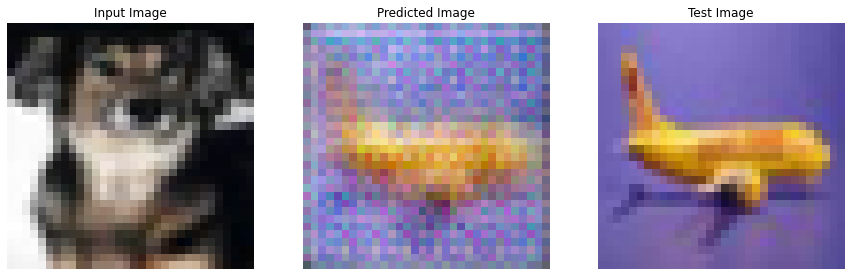

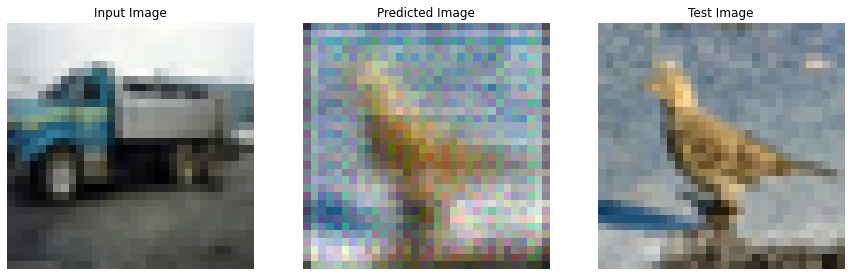

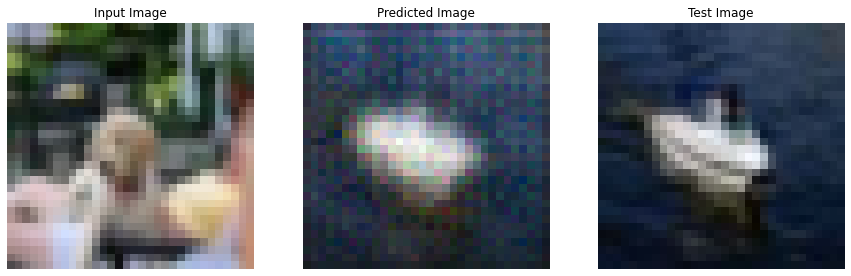

In [42]:
# code test
for i in range(3):
    display([train_data["inputs"].numpy()[i], pseudo_inputs.numpy()[i], test_data["inputs"].numpy()[i]])


In [ ]:
# training
obtain_model_opts(sample_start=30, sample_gap=5) 
print(len(model_opt))

In [ ]:
# save model opt
hard_save_model_opt(model_opt)

In [ ]:
# load model opt
model_opt = load_model_opt()

In [ ]:
# metrics visualization
plot_train([records.train_loss, records.test_loss])
plot_train([opt_label, opt_label])

In [ ]:
train_data = iter_train.get_next()

unet = UNet(input_shape=[32, 32, 3])
output = unet(train_data["inputs"])
print(output.shape)
display([train_data["inputs"].numpy()[0],output.numpy()[0]])